In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import torchvision
import torch
import torch.optim as optim
from torchvision import transforms, models

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is not available. Training on CPU...


In [3]:

# Get the VGG19 features
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters (because we're only optimizing the target image)
for param in vgg.parameters():
    param.requires_grad_(False)

In [4]:
# Move the model to GPU if available
if train_on_gpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [5]:

# Helper function to load in any type and size of image + converts images to normalized tensors
def load_image(img_path, max_size=400, shape=None):
    """
    Load in and transform an image, making sure the
    image is <= 400 pixels in the x-y dims
    """
    
    image = Image.open(img_path).convert('RGB')
    
    # Large images will slow down procressing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    img_transform = transforms.Compose([transforms.Resize(size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    # Discard the transparent alpha channel
    image = img_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [6]:
# Load in content and style image
content = load_image("examples/input/in12.png").to(device)

# Resize style to match content, makes code easier
style = load_image("examples/style/tar12.png", shape=content.shape[-2:]).to(device)

In [7]:
# Helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image
def img_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0,1)
    
    return image

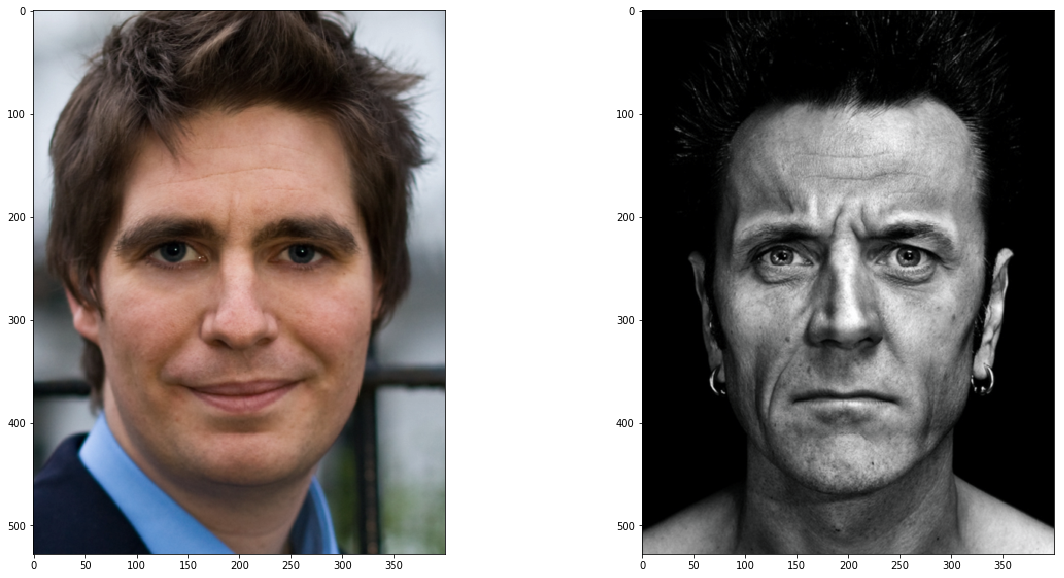

In [8]:
# Display the images
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

# Content and style ims side-by-side
ax1.imshow(img_convert(content))
ax2.imshow(img_convert(style))

In [9]:
def get_features(image, model, layers=None):
    """
    Run an image forward through a model and get the features
    for a set of layers.
    """
    
    # Mapping layer names of PyTorch's VGG16 implementation
    # Needs the layers for content and style representation
    # Content representation needs output of layer conv4_2
    # Style representation conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', # Content representation
                  '28': 'conv5_1'
                 }
    
    features = {}
    x = image
    
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
        
    return features

In [10]:
def gram_matrix(tensor):
    """
    Calculate the Gram matrix of a given tensor
    """
    
    # Get the depth, height and width of a tensor
    _, d, h, w = tensor.size()
    
    # Reshape the tensor so that the spatial dim are flattened
    tensor = tensor.view(d, h*w)
    
    # Calculate the gram matrix by * the reshaped tensor by its transpose
    # Multiply all the features and gets the correlations
    gram_matrix = torch.mm(tensor, tensor.t())
    
    return gram_matrix


In [11]:
# Get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a thir target image and prepare it for change
# We copy our content image
target = content.clone().requires_grad_(True).to(device)

In [12]:

# Weights for each style layer
# Weighting earlier layers more will result in larger style artifacts
# We exclude conv4_2 (content representation)
style_weights = {'conv1_1': 1.,
                'conv2_1': 0.75,
                'conv3_1': 0.2,
                'conv4_1': 0.2,
                'conv5_1': 0.1}

# Define the alpha and beta
alpha = 1
beta = 1e6

In [13]:
itr = 0
def save_img(target):
    torchvision.utils.save_image(tt,'sample.png')

Epoch n° 2  /// Total Loss:  53615024.0


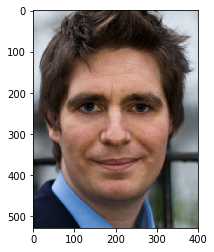

Epoch n° 4  /// Total Loss:  51471476.0


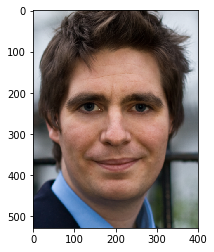

KeyboardInterrupt: 

In [14]:
# Show the target picture
show_every = 250

# Iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 5000

for ii in range (1, steps+1):
    # Get the features from our target image
    # Calculate the content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # The style loss
    # Initialize the style loss to 0
    style_loss = 0
    
    # Iterate through each style layer and add to the style loss
    for layer in style_weights:
        # Get the target style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # Calculate the gram matrix
        target_gram = gram_matrix(target_feature)
        
        # Get the style style representation
        style_gram = style_grams[layer]
        
        # The style loss for one layer weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # The style loss
        style_loss += layer_style_loss / (d*h*w)
        
    # Calculate the total loss
    total_loss = alpha * content_loss + beta * style_loss
    
    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # Display intermediate images and print the loss
    if ii % 2 == 0:
        print("Epoch n°", ii, " /// Total Loss: ", total_loss.item())
        plt.imshow(img_convert(target))
        #target.save("sample.png", "")
        tt = target.clone() # pytorch doesn't allow in-place operation on variable
        #save_img(tt)
        name = "At_Epoch"+str(ii)+".png"
        torchvision.utils.save_image(tt,name)
        plt.show()


In [ ]:
from PIL import Image
""" Some Code """
img.save("sample.png", "")